# Seurat: normalisation, clustering and visualisation

In [1]:
suppressPackageStartupMessages({
    library(Matrix)
    library(scater)
    library(Seurat)
    library(data.table)
    library(cowplot)
    library(dplyr)
})

In [2]:
packageVersion("Seurat")

[1] ‘4.0.5’

## Loading the data

Import the `SingleCellExperiment` object made in the `scater` notebook.

In [3]:
sce <- readRDS(file = "./1.scater/Bohm_QCfiltered.Rds")
dim(sce)

[1] 27343   168

In [4]:
# dir.create("2.Seurat")
setwd("./2.Seurat/")

In [5]:
osx <- as.Seurat(sce, counts = "counts", data = "logcounts")

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from PC to PC_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to PC_”


In [6]:
osx

An object of class Seurat 
27343 features across 168 samples within 1 assay 
Active assay: originalexp (27343 features, 0 variable features)
 1 dimensional reduction calculated: PCA_coldata

## Data preprocessing

### Importing and apppending the metadata

In [7]:
osx.metadata <- read.table(file = "../1.scater/metadata.tsv", sep = "\t", row.names = 1)
colnames(osx.metadata) <- c("Origin", "Tracer", "Organism", "Tech")
head(osx.metadata, 5)

,Origin,Tracer,Organism,Tech
,<chr>,<chr>,<chr>,<chr>
ERR3427950,Tibia,Osx-GFP+,Mouse,SMART-Seq2
ERR3427951,Tibia,Osx-GFP+,Mouse,SMART-Seq2
ERR3427952,Tibia,Osx-GFP+,Mouse,SMART-Seq2
ERR3427953,Tibia,Osx-GFP+,Mouse,SMART-Seq2
ERR3427954,Tibia,Osx-GFP+,Mouse,SMART-Seq2


In [8]:
osx <- AddMetaData(osx, osx.metadata)

In [9]:
osx@meta.data[1:5, 1:5]

,orig.ident,nCount_originalexp,nFeature_originalexp,Cells,Origin
,<fct>,<dbl>,<int>,<fct>,<chr>
ERR3427950,SeuratProject,286985,7457,ERR3427950,Tibia
ERR3427951,SeuratProject,531757,7599,ERR3427951,Tibia
ERR3427952,SeuratProject,410574,6498,ERR3427952,Tibia
ERR3427953,SeuratProject,264937,5211,ERR3427953,Tibia
ERR3427954,SeuratProject,391436,5869,ERR3427954,Tibia


## Normalisation

In [10]:
osx <- NormalizeData(object = osx, 
                     normalization.method = "LogNormalize", 
                     scale.factor = 10000)

In [11]:
osx <- FindVariableFeatures(object = osx, mean.function = ExpMean, 
                            dispersion.function = LogVMR)

When using repel, set xnudge and ynudge to 0 for optimal results



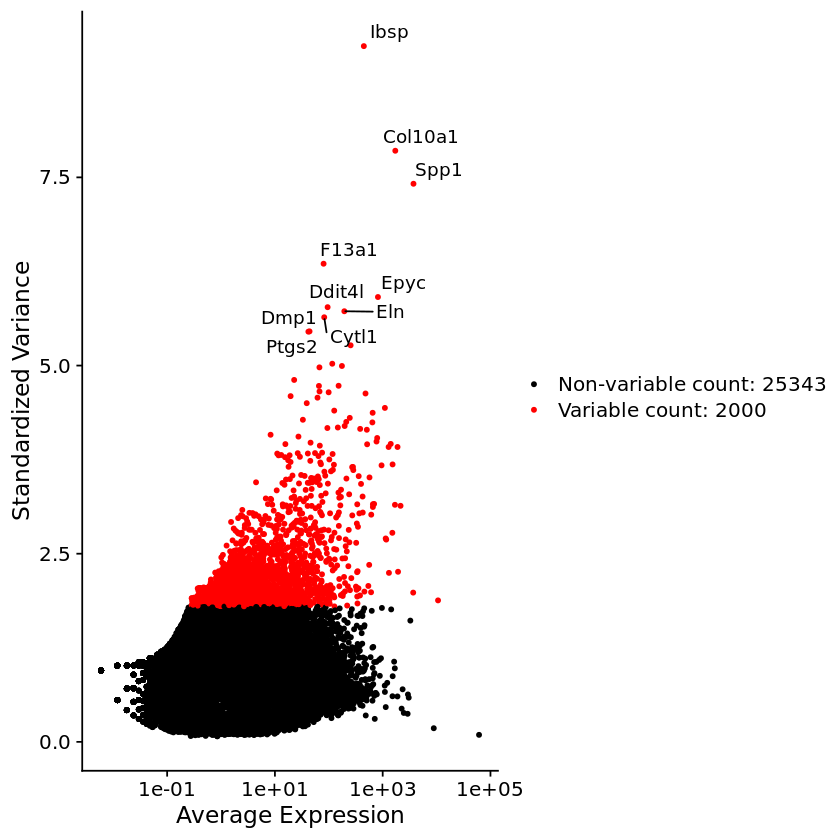

In [12]:
top10 <- head(VariableFeatures(osx), 10)

plot1 <- VariableFeaturePlot(osx)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2

## Scaling the data

Next, we apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The `ScaleData` function:

- Shifts the expression of each gene, so that the mean expression across cells is 0
- Scales the expression of each gene, so that the variance across cells is 1
    This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
- The results of this are stored in osx[["RNA"]]@scale.data

### Regressing out latent variables: %Mito and nUMI

In [13]:
mito.genes <- grep(pattern = "mt-", x = rownames(x = GetAssayData(object = osx)), value = TRUE)
percent.mito <- Matrix::colSums(GetAssayData(object = osx)[mito.genes, ])/Matrix::colSums(GetAssayData(object = osx, slot = "counts")) * 100

In [14]:
osx <- AddMetaData(object = osx, 
                   metadata = percent.mito,
                   col.name = "percent.mito")

In [15]:
# linear regression model
all.genes <- rownames(osx)
osx.lin <- ScaleData(osx, features = all.genes, vars.to.regress = c("percent.mito", "nCount_RNA"))

Warning message:
“Requested variables to regress not in object: nCount_RNA”
Regressing out percent.mito

Centering and scaling data matrix



In [ ]:
# osx.negbinom <- ScaleData(object = osx, 
#                           features = all.genes, 
#                           vars.to.regress = c("percent.mito", "nCount_RNA"),
#                           model.use = "negbinom")

Warning message:
“Requested variables to regress not in object: nCount_RNA”
Regressing out percent.mito

Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$tra

## Dimensionality reduction

In [16]:
osx.lin <- RunPCA(object = osx.lin, pc.genes = VariableFeatures(object = osx))
# osx.negbinom <- RunPCA(object = osx.negbinom, pc.genes = VariableFeatures(object = osx))

PC_ 1 
Positive:  Col1a1, Postn, Aspn, Col3a1, Ptn, Mfap4, Lgals1, Thbs2, Col8a2, Bgn 
	   Ogn, Fstl1, Serpinf1, Tubb5, Cdh11, Tpm1, Olfml3, Igfbp4, Zfhx4, Col12a1 
	   Csrp2, Tmem119, Crabp1, Fbn2, Col14a1, Tspan7, Ctsk, Ptprv, Crabp2, Eln 
Negative:  Hapln1, Col11a2, Col2a1, Comp, Snorc, Col9a1, Lgals3, Col9a3, Col9a2, Matn1 
	   Cnmd, Sdc4, Ncmap, Matn3, Cspg4, Panx3, Fbln7, Fam180a, Ugdh, Pcolce2 
	   Smpd3, Acan, Susd5, Itih5l-ps, Gale, 4930523C07Rik, Trpv4, Foxa3, Klhl13, Scin 
PC_ 2 
Positive:  Spp1, Ddit4l, F13a1, Ibsp, Fam20c, Steap4, Phex, Col10a1, Dmp1, Serpini1 
	   Serpine2, Tcim, Frmd4b, Tmsb4x, Anxa3, Mmp13, Jam2, Itga2, Slc29a1, Hpgd 
	   Emb, Insig2, Itm2b, Tspan13, Gm42793, Sulf1, Arap2, Spint2, Itgb3, Irx5 
Negative:  Bcat1, C1qtnf3, Fibin, Nid2, Scrg1, Rcn1, Mest, Slc16a3, P4ha1, Tgfbi 
	   Ppa1, Epyc, Ctsz, Papss2, Car12, Rtl3, Meltf, Chst11, H2-DMa, Penk 
	   H2-DMb1, S100b, Chrdl1, Sparcl1, Ccn1, Atoh8, Snai1, Pygl, Gfod1, Slc44a2 
PC_ 3 
Positive:  Aurkb, Mki67,

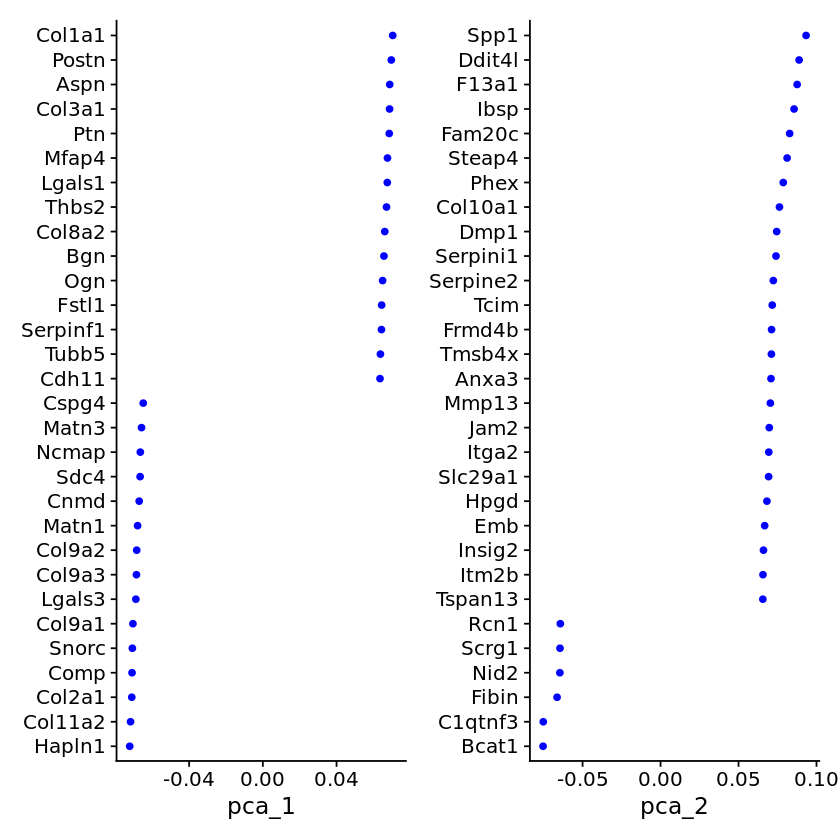

In [17]:
VizDimLoadings(osx.lin, dims = 1:2, reduction = "pca")

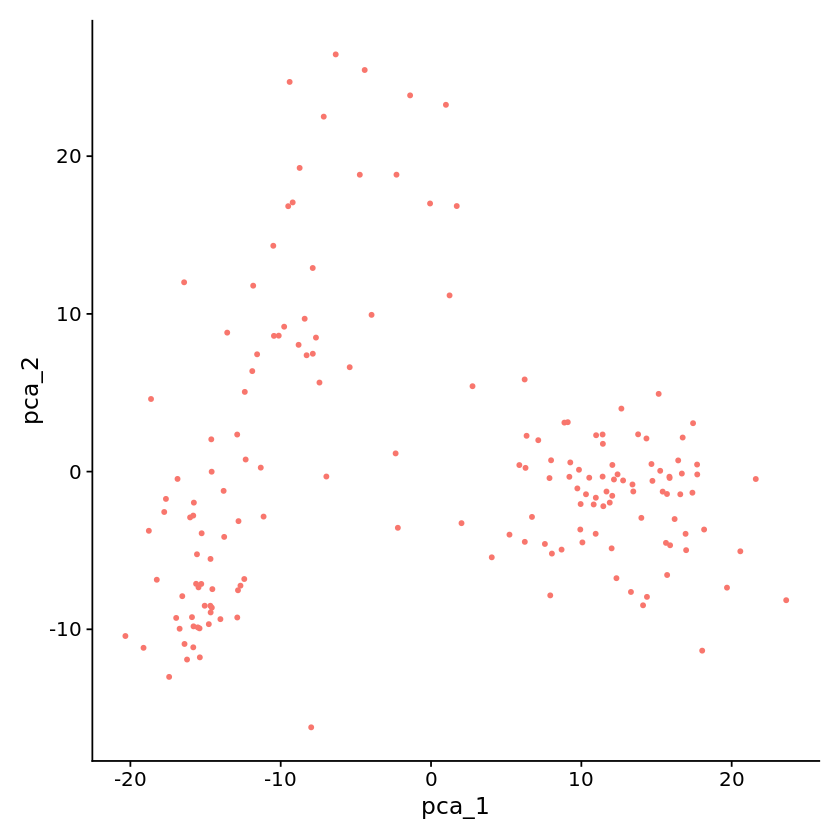

In [18]:
p1 <- DimPlot(osx.lin, reduction = "pca") + NoLegend()
# p2 <- DimPlot(osx.negbinom, reduction = "pca") + NoLegend()

p1

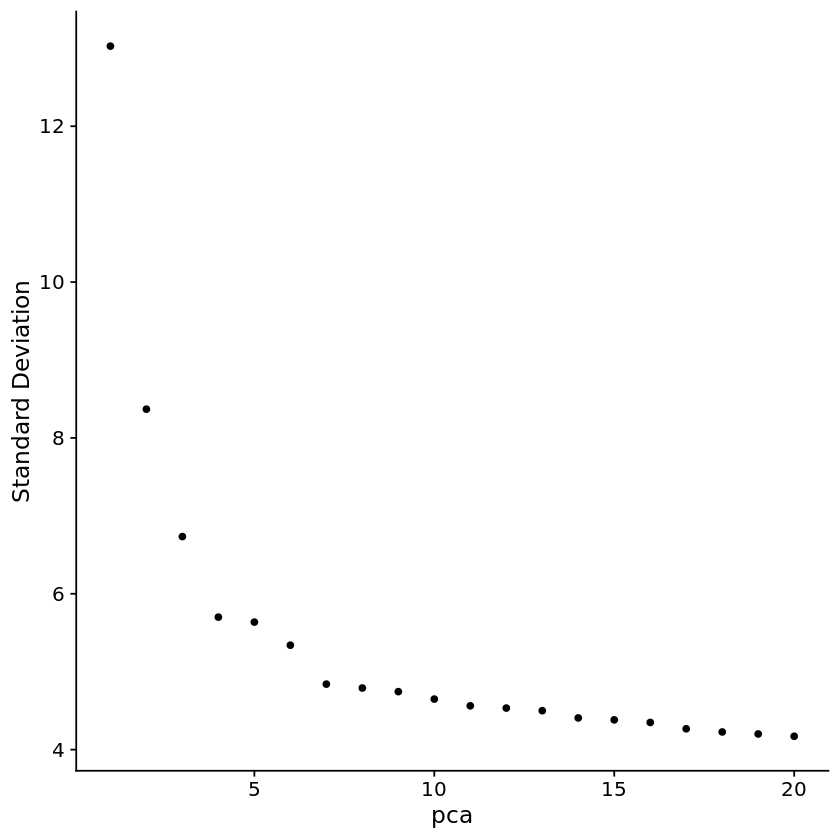

In [19]:
ElbowPlot(osx.lin)

#### Assign cell cycle scores

First we assign each cell a score based on its expression of G2/M and S phase markers. These marker sets should be anticorrelated in their expression levels. Cells expressing neither are likely not cycling and in G1 phase.

We assign cscores in the `CellCycleScoring` function, which stores S and G2/M scores in object metadata, along with the predicted classification of each cell in either G1, S or G2/M phase. `CellCycleScoring` can also set the identity of the Seurat object to the cell-cycle phase by passing `set.ident = TRUE`. The original identities are then stored in `old.ident`. Note that Seurat does not use the discrete classifications (G1, S, G2/M) in downstream cell cycle regression. Instead, it uses the quantitative scores for G2/M and S phase.

In [21]:
mouse.cc.genes <- readRDS(file = "/mnt/c/Users/u0124158/Documents/NGS/data/mouse_cell_cycle_genes/mouse_cell_cycle_genes.rds")

s.genes <- mouse.cc.genes$s.genes
g2m.genes <- mouse.cc.genes$g2m.genes

In [22]:
osx.lin <- CellCycleScoring(osx.lin, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
osx.negbinom <- CellCycleScoring(osx.negbinom, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

In [23]:
head(osx.lin@meta.data[, c(1:5, 46:48)])

,Cells,Origin,CellType,Organism,Tech,S.Score,G2M.Score,Phase
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
ERR3427950,ERR3427950,Tibia,Osx-GFP+,Mouse,SMART-Seq2,0.23812094,-0.10942807,S
ERR3427951,ERR3427951,Tibia,Osx-GFP+,Mouse,SMART-Seq2,-0.14485951,-0.11362718,G1
ERR3427952,ERR3427952,Tibia,Osx-GFP+,Mouse,SMART-Seq2,-0.10180711,-0.08172055,G1
ERR3427953,ERR3427953,Tibia,Osx-GFP+,Mouse,SMART-Seq2,-0.22841431,-0.08248695,G1
ERR3427954,ERR3427954,Tibia,Osx-GFP+,Mouse,SMART-Seq2,-0.09319376,-0.07690033,G1
ERR3427955,ERR3427955,Tibia,Osx-GFP+,Mouse,SMART-Seq2,-0.13696142,-0.12655589,G1


In [24]:
head(osx.negbinom@meta.data[, c(1:5, 46:48)])

,Cells,Origin,CellType,Organism,Tech,S.Score,G2M.Score,Phase
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
ERR3427950,ERR3427950,Tibia,Osx-GFP+,Mouse,SMART-Seq2,0.23812094,-0.10942807,S
ERR3427951,ERR3427951,Tibia,Osx-GFP+,Mouse,SMART-Seq2,-0.14485951,-0.11362718,G1
ERR3427952,ERR3427952,Tibia,Osx-GFP+,Mouse,SMART-Seq2,-0.10180711,-0.08172055,G1
ERR3427953,ERR3427953,Tibia,Osx-GFP+,Mouse,SMART-Seq2,-0.22841431,-0.08248695,G1
ERR3427954,ERR3427954,Tibia,Osx-GFP+,Mouse,SMART-Seq2,-0.09319376,-0.07690033,G1
ERR3427955,ERR3427955,Tibia,Osx-GFP+,Mouse,SMART-Seq2,-0.13696142,-0.12655589,G1


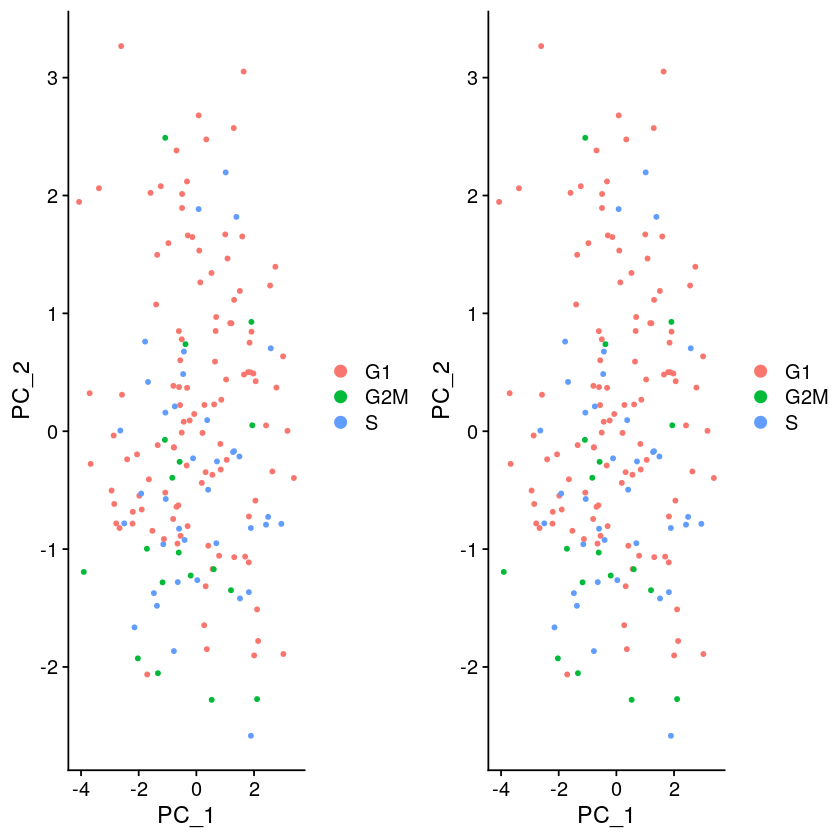

In [25]:
PCA.cc.lin <- DimPlot(osx.lin)
PCA.cc.negbinom <- DimPlot(osx.negbinom)

plot_grid(PCA.cc.lin, PCA.cc.negbinom)

## Clustering

The stochastic sampling of counts can be modeled using a Gamma-Poisson distribution, more colloquially known as the ‘negative binomial’ distribution. This is why in my opinion the negative binomial distribution better reflects random gene expression sampling.

In [20]:
osx <- FindNeighbors(osx.lin, dims = 1:11)
osx <- FindClusters(osx, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 168
Number of edges: 4301

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7455
Number of communities: 3
Elapsed time: 0 seconds


## Non-linear dimensionality reduction

In [21]:
osx <- RunTSNE(osx, dims = 1:11)
osx <- RunUMAP(osx, dims = 1:11)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:00:26 UMAP embedding parameters a = 0.9922 b = 1.112

21:00:26 Read 168 rows and found 11 numeric columns

21:00:26 Using Annoy for neighbor search, n_neighbors = 30

21:00:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:00:27 Writing NN index file to temp file /tmp/RtmpXxbY6N/file41013b1ceab

21:00:27 Searching Annoy index using 1 thread, search_k = 3000

21:00:27 Annoy recall = 100%

21:00:27 Commencing smooth kNN distance calibration using 1 thread

21:00:28 Initializing from 

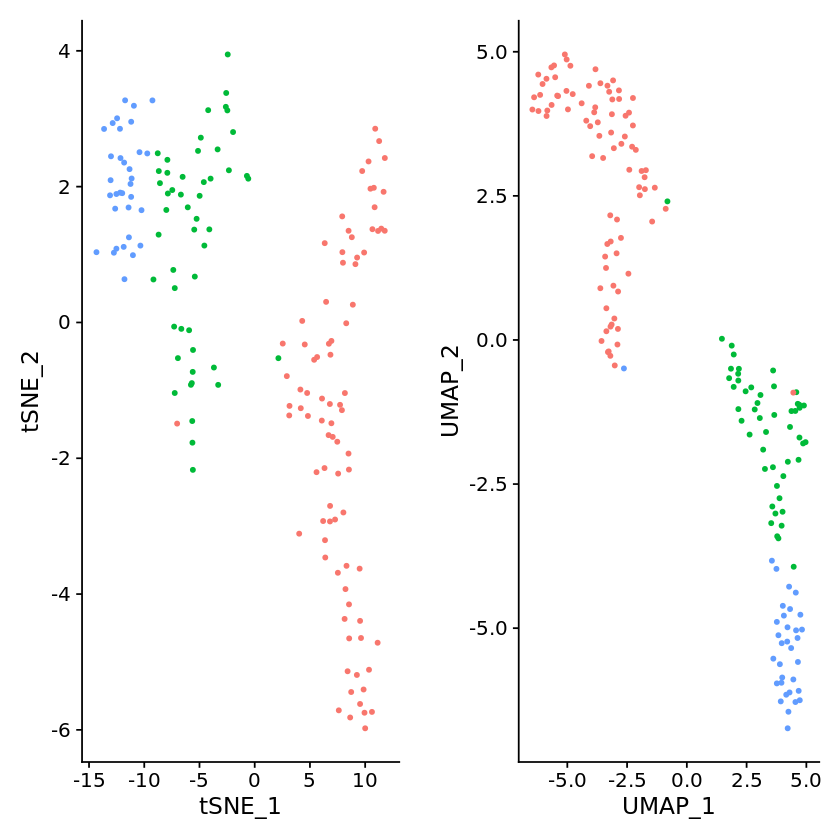

In [22]:
p1 <- DimPlot(osx, reduction = "tsne") + NoLegend()
p2 <- DimPlot(osx, reduction = "umap") + NoLegend()

plot_grid(p1, p2)

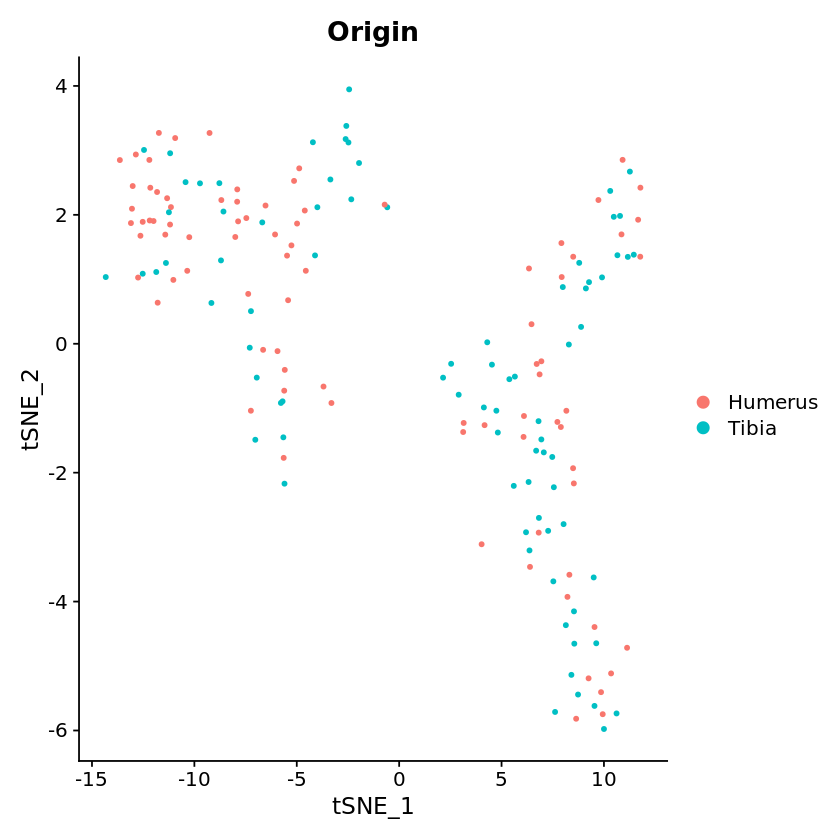

In [23]:
DimPlot(osx, reduction = "tsne", group.by = "Origin")

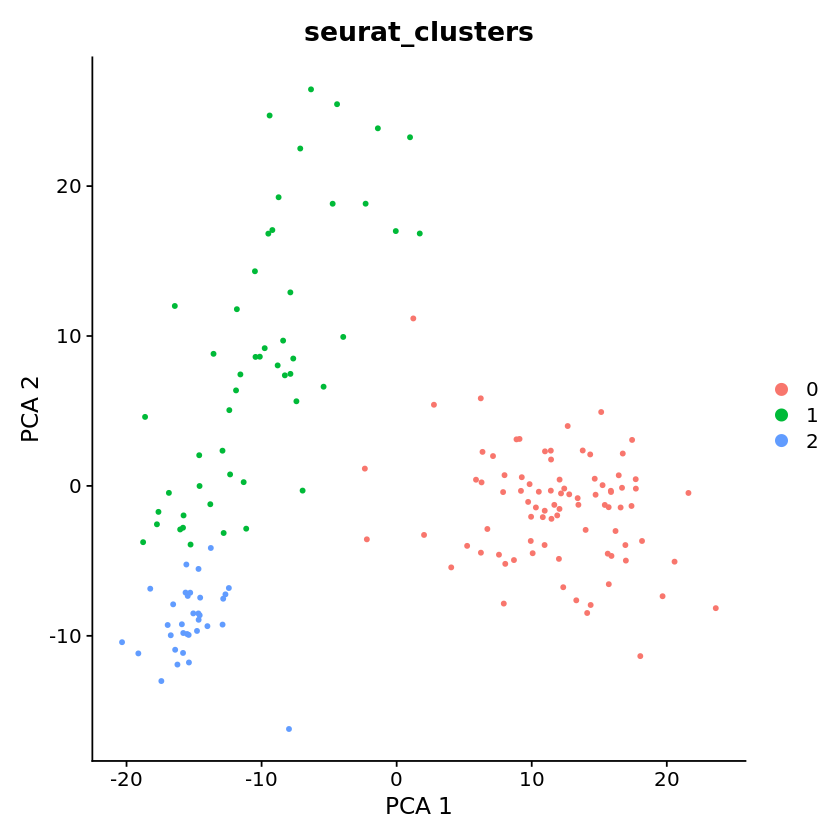

In [24]:
DimPlot(osx, reduction = "pca", group.by = "seurat_clusters") +
   xlab("PCA 1") +
   ylab("PCA 2")

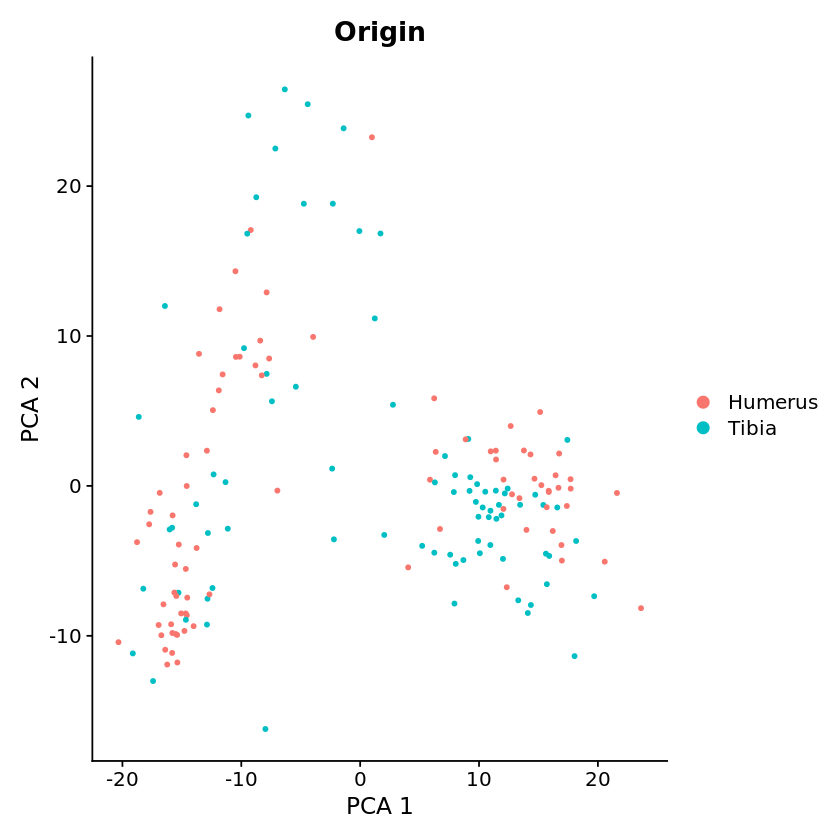

In [25]:
DimPlot(osx, reduction = "pca", group.by = "Origin") +
   xlab("PCA 1") +
   ylab("PCA 2")

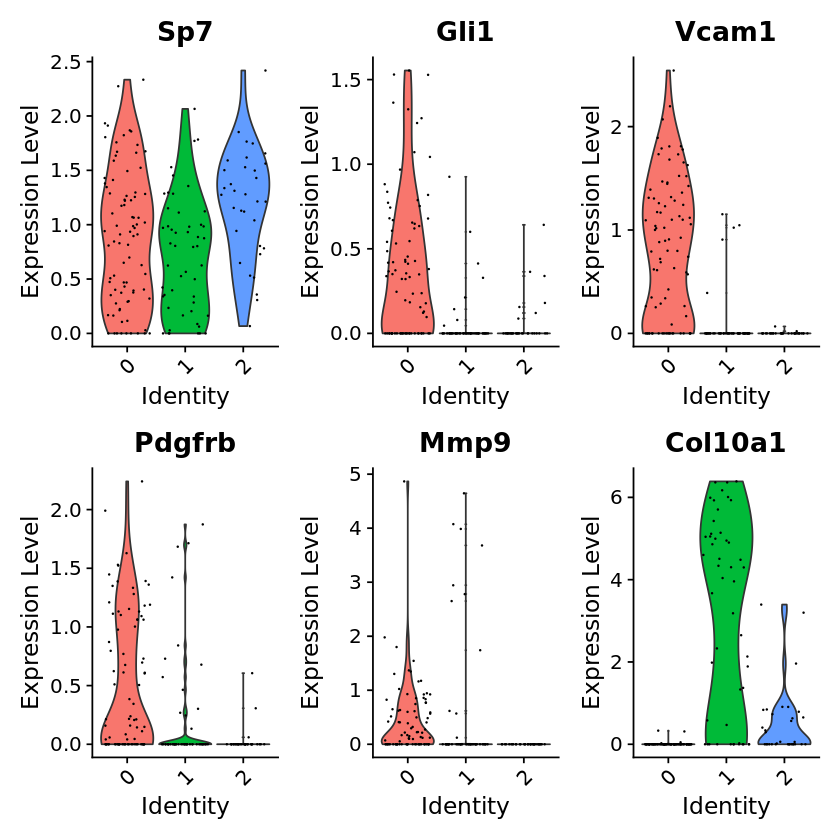

In [26]:
VlnPlot(osx, features = c("Sp7", "Gli1", "Vcam1", "Pdgfrb", "Mmp9", "Col10a1"))

Chondromodulin (Cnmd) is predominately expressed in the prehypertrophic zone of growth plate cartilage, where it promotes chondrocyte growth and inhibits angiogenesis. Its expression decreases during chondrocyte hypertrophy and vascular invasion. The mature protein likely plays a role in endochondral bone development by permitting cartilaginous anlagen to be vascularized and replaced by bone.

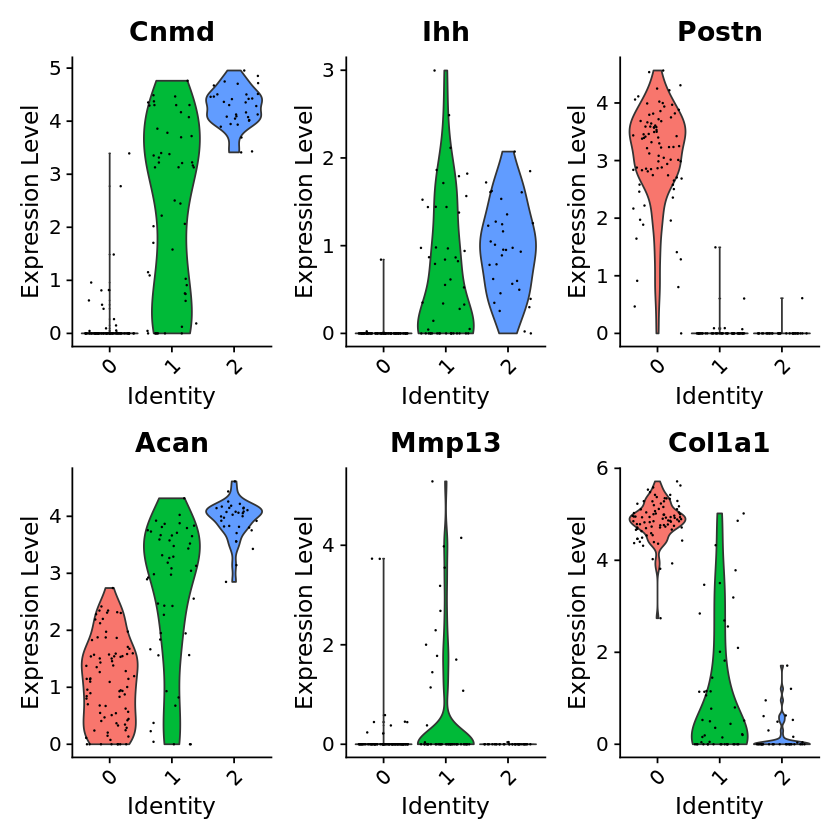

In [27]:
VlnPlot(osx, features = c("Cnmd", "Ihh", "Postn", "Acan", "Mmp13", "Col1a1"))

In [28]:
osx.markers <- FindAllMarkers(osx, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2



Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


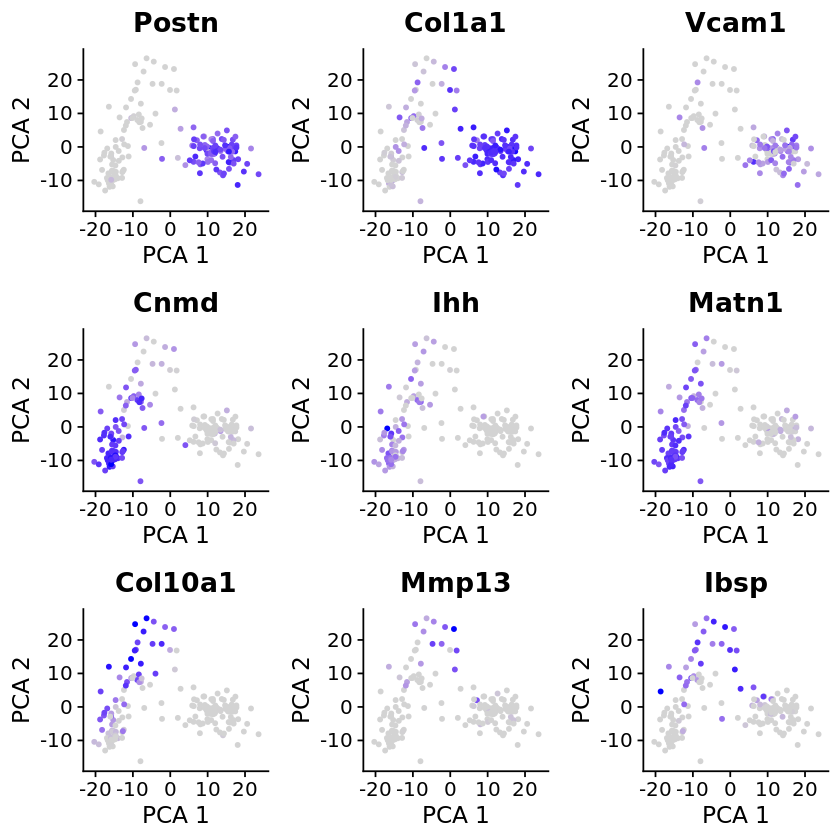

In [30]:
plots <- FeaturePlot(osx, features = c("Postn", "Col1a1", "Vcam1", 
                              "Cnmd", "Ihh", "Matn1",
                              "Col10a1", "Mmp13", "Ibsp"), 
                     reduction = "pca", combine = FALSE)
plots <- lapply(X = plots, FUN = function(p) p + xlab("PCA 1") + ylab("PCA 2") + theme(legend.position = "none") )
CombinePlots(plots = plots)

In [ ]:
top10 <- osx.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(osx, features = top10$gene) + NoLegend()

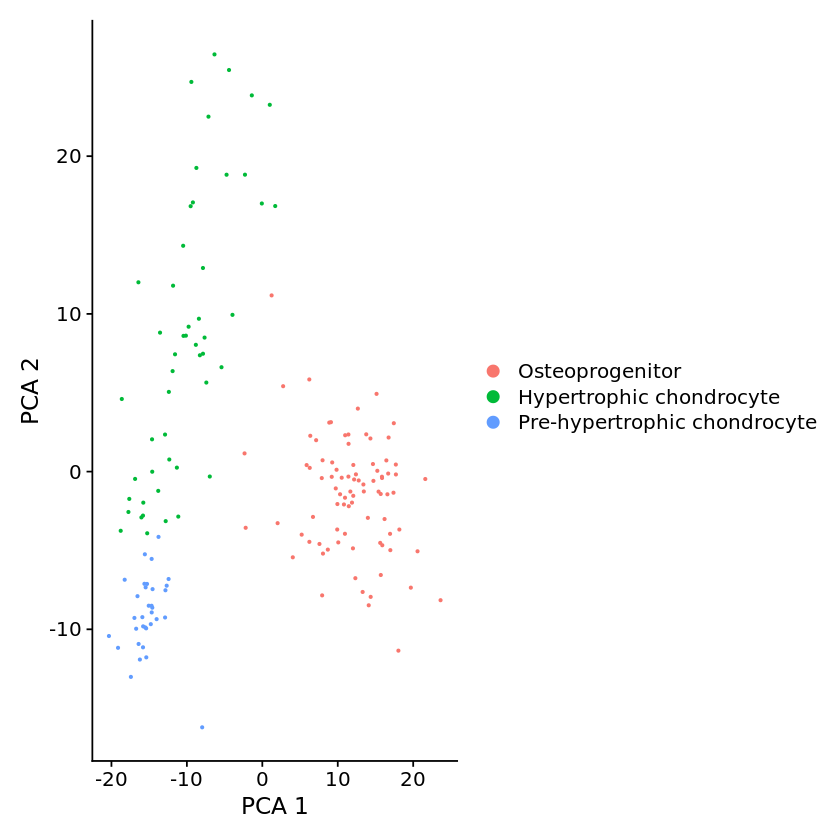

In [31]:
new.cluster.ids <- c("Osteoprogenitor", "Hypertrophic chondrocyte", "Pre-hypertrophic chondrocyte")
names(new.cluster.ids) <- levels(osx)
osx <- RenameIdents(osx, new.cluster.ids)

DimPlot(osx, reduction = "pca", label = FALSE, pt.size = 0.5) + xlab("PCA 1") + ylab("PCA 2")

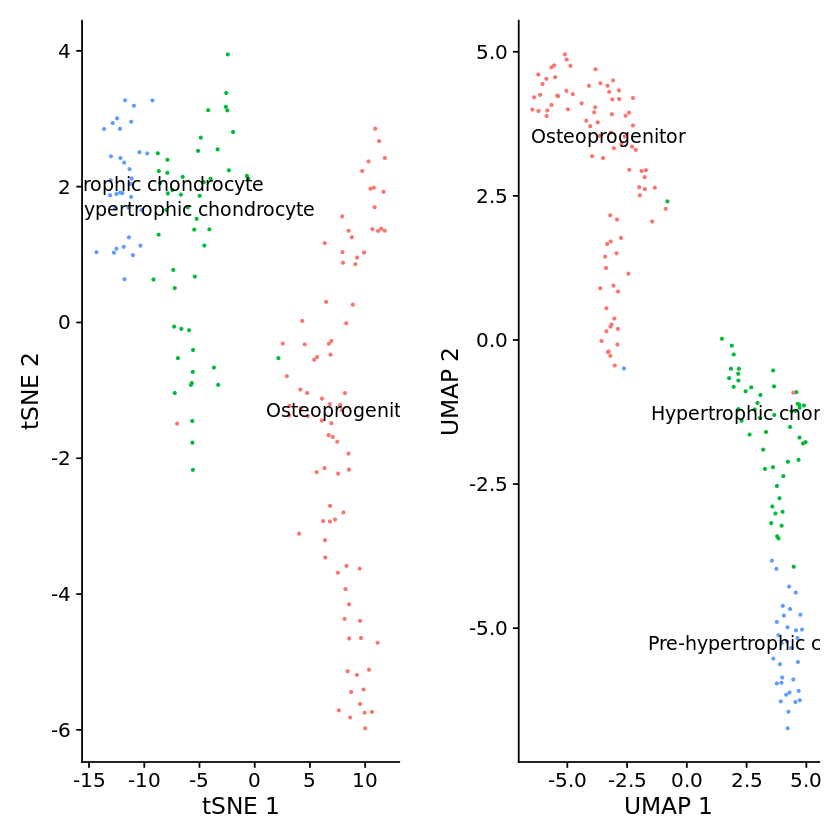

In [32]:
p1 <- DimPlot(osx, reduction = "tsne", label = TRUE, pt.size = 0.5) + xlab("tSNE 1") + ylab("tSNE 2") + NoLegend()
p2 <- DimPlot(osx, reduction = "umap", label = TRUE, pt.size = 0.5) + xlab("UMAP 1") + ylab("UMAP 2") + NoLegend()

plot_grid(p1, p2)

In [33]:
saveRDS(osx, "osx_positive_cells_SeuratObject.Rds")

In [3]:
setwd("./2.Seurat/")
osx <- readRDS(file = "osx_positive_cells_SeuratObject.Rds")

In [7]:
# Idents(osx)
head(osx@meta.data)

,Cells,Origin,CellType,Organism,Tech,is_cell_control,total_features_by_counts,log10_total_features_by_counts,total_counts,log10_total_counts,⋯,outlier,nCount_RNA,nFeature_RNA,percent.mito,S.Score,G2M.Score,Phase,old.ident,RNA_snn_res.0.5,seurat_clusters
,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<int>,<dbl>,⋯,<lgl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
ERR3427950,ERR3427950,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,7457,3.872622,286985,5.457861,⋯,FALSE,286985,7457,0.011176198,0.23812094,-0.10942807,S,SingleCellExperiment,0,0
ERR3427951,ERR3427951,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,7599,3.880814,531757,5.725714,⋯,FALSE,531757,7599,0.005401442,-0.14485951,-0.11362718,G1,SingleCellExperiment,1,1
ERR3427952,ERR3427952,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,6498,3.812847,410574,5.613393,⋯,FALSE,410574,6498,0.007615103,-0.10180711,-0.08172055,G1,SingleCellExperiment,0,0
ERR3427953,ERR3427953,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,5211,3.717004,264937,5.423144,⋯,FALSE,264937,5211,0.009641769,-0.22841431,-0.08248695,G1,SingleCellExperiment,2,2
ERR3427954,ERR3427954,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,5869,3.768638,391436,5.592662,⋯,FALSE,391436,5869,0.007520422,-0.09319376,-0.07690033,G1,SingleCellExperiment,2,2
ERR3427955,ERR3427955,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,6006,3.778658,482848,5.683811,⋯,FALSE,482848,6006,0.005494778,-0.13696142,-0.12655589,G1,SingleCellExperiment,0,0


In [9]:
osx <- AddMetaData(osx, Idents(osx))
osx@meta.data

ERROR: Error in .AddMetaData(object = object, metadata = metadata, col.name = col.name): 'col.name' must be provided for atomic metadata types (eg. vectors)


In [16]:
Identity <- Idents(osx)
IdentityDF <- as.data.frame(Identity)

osx <- AddMetaData(osx, IdentityDF)
head(osx@meta.data)

,Cells,Origin,CellType,Organism,Tech,is_cell_control,total_features_by_counts,log10_total_features_by_counts,total_counts,log10_total_counts,⋯,nCount_RNA,nFeature_RNA,percent.mito,S.Score,G2M.Score,Phase,old.ident,RNA_snn_res.0.5,seurat_clusters,Identity
,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<int>,<dbl>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
ERR3427950,ERR3427950,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,7457,3.872622,286985,5.457861,⋯,286985,7457,0.011176198,0.23812094,-0.10942807,S,SingleCellExperiment,0,0,Osteoprogenitor
ERR3427951,ERR3427951,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,7599,3.880814,531757,5.725714,⋯,531757,7599,0.005401442,-0.14485951,-0.11362718,G1,SingleCellExperiment,1,1,Prehypertrophic chondrocyte
ERR3427952,ERR3427952,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,6498,3.812847,410574,5.613393,⋯,410574,6498,0.007615103,-0.10180711,-0.08172055,G1,SingleCellExperiment,0,0,Osteoprogenitor
ERR3427953,ERR3427953,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,5211,3.717004,264937,5.423144,⋯,264937,5211,0.009641769,-0.22841431,-0.08248695,G1,SingleCellExperiment,2,2,Hypertrophic chondrocyte
ERR3427954,ERR3427954,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,5869,3.768638,391436,5.592662,⋯,391436,5869,0.007520422,-0.09319376,-0.07690033,G1,SingleCellExperiment,2,2,Hypertrophic chondrocyte
ERR3427955,ERR3427955,Tibia,Osx-GFP+,Mouse,SMART-Seq2,FALSE,6006,3.778658,482848,5.683811,⋯,482848,6006,0.005494778,-0.13696142,-0.12655589,G1,SingleCellExperiment,0,0,Osteoprogenitor


In [17]:
colnames(osx@meta.data)

[1] "Cells"                                         
 [2] "Origin"                                        
 [3] "CellType"                                      
 [4] "Organism"                                      
 [5] "Tech"                                          
 [6] "is_cell_control"                               
 [7] "total_features_by_counts"                      
 [8] "log10_total_features_by_counts"                
 [9] "total_counts"                                  
[10] "log10_total_counts"                            
[11] "pct_counts_in_top_50_features"                 
[12] "pct_counts_in_top_100_features"                
[13] "pct_counts_in_top_200_features"                
[14] "pct_counts_in_top_500_features"                
[15] "total_features_by_counts_endogenous"           
[16] "log10_total_features_by_counts_endogenous"     
[17] "total_counts_endogenous"                       
[18] "log10_total_counts_endogenous"                 
[19] "pct_counts_endogenous"                         
[20] "pct_counts_in_top_50_features_endogenous"      
[21] "pct_counts_in_top_100_features_endogenous"     
[22] "pct_counts_in_top_200_features_endogenous"     
[23] "pct_counts_in_top_500_features_endogenous"     
[24] "total_features_by_counts_feature_control"      
[25] "log10_total_features_by_counts_feature_control"
[26] "total_counts_feature_control"                  
[27] "log10_total_counts_feature_control"            
[28] "pct_counts_feature_control"                    
[29] "pct_counts_in_top_50_features_feature_control" 
[30] "pct_counts_in_top_100_features_feature_control"
[31] "pct_counts_in_top_200_features_feature_control"
[32] "pct_counts_in_top_500_features_feature_control"
[33] "total_features_by_counts_Mt"                   
[34] "log10_total_features_by_counts_Mt"             
[35] "total_counts_Mt"                               
[36] "log10_total_counts_Mt"                         
[37] "pct_counts_Mt"                                 
[38] "pct_counts_in_top_50_features_Mt"              
[39] "pct_counts_in_top_100_features_Mt"             
[40] "pct_counts_in_top_200_features_Mt"             
[41] "pct_counts_in_top_500_features_Mt"             
[42] "outlier"                                       
[43] "nCount_RNA"                                    
[44] "nFeature_RNA"                                  
[45] "percent.mito"                                  
[46] "S.Score"                                       
[47] "G2M.Score"                                     
[48] "Phase"                                         
[49] "old.ident"                                     
[50] "RNA_snn_res.0.5"                               
[51] "seurat_clusters"                               
[52] "Identity"

In [27]:
metadata <- osx@meta.data[, c(2,3,4,5,52)]
metadata$DevTP <- "E15.5"
metadata$Author <- "Böhm"

,Origin,CellType,Organism,Tech,Identity,DevTP,Author
,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>
ERR3427950,Tibia,Osx-GFP+,Mouse,SMART-Seq2,Osteoprogenitor,E15.5,Böhm
ERR3427951,Tibia,Osx-GFP+,Mouse,SMART-Seq2,Prehypertrophic chondrocyte,E15.5,Böhm
ERR3427952,Tibia,Osx-GFP+,Mouse,SMART-Seq2,Osteoprogenitor,E15.5,Böhm
ERR3427953,Tibia,Osx-GFP+,Mouse,SMART-Seq2,Hypertrophic chondrocyte,E15.5,Böhm
ERR3427954,Tibia,Osx-GFP+,Mouse,SMART-Seq2,Hypertrophic chondrocyte,E15.5,Böhm
ERR3427955,Tibia,Osx-GFP+,Mouse,SMART-Seq2,Osteoprogenitor,E15.5,Böhm


In [31]:
metadata <- metadata[, c(3,1,2,5,6,4,7)]

In [33]:
head(metadata)

,Organism,Origin,CellType,Identity,DevTP,Tech,Author
,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>,<chr>
ERR3427950,Mouse,Tibia,Osx-GFP+,Osteoprogenitor,E15.5,SMART-Seq2,Böhm
ERR3427951,Mouse,Tibia,Osx-GFP+,Prehypertrophic chondrocyte,E15.5,SMART-Seq2,Böhm
ERR3427952,Mouse,Tibia,Osx-GFP+,Osteoprogenitor,E15.5,SMART-Seq2,Böhm
ERR3427953,Mouse,Tibia,Osx-GFP+,Hypertrophic chondrocyte,E15.5,SMART-Seq2,Böhm
ERR3427954,Mouse,Tibia,Osx-GFP+,Hypertrophic chondrocyte,E15.5,SMART-Seq2,Böhm
ERR3427955,Mouse,Tibia,Osx-GFP+,Osteoprogenitor,E15.5,SMART-Seq2,Böhm


In [32]:
write.table(metadata, "Bohm_metadata.tsv", sep = "\t", quote = FALSE)

In [25]:
raw.data <- GetAssayData(osx, slot = "counts")
write.table(raw.data, "Bohm_rawdata.tsv", sep = "\t", quote = FALSE)

In [26]:
saveRDS(GetAssayData(osx, slot = "counts"), file = "Bohm_rawdata.Rds")